# Photoshop Blend Modes with Python numpy

In [1]:
from PIL import Image
from IPython.display import display
from io import BytesIO
import urllib
import requests
import numpy as np
import matplotlib.pyplot as plt

Some utility functions we need later on

In [2]:
# Display ndarray as image using matplotlib
def display_img(img_data):
    img = Image.fromarray(img_data)
    display(img)

def convert_uint_to_float(img_data):
    return img_data / 255
    
def convert_float_to_uint(img_data):
    return round_to_uint(img_data * 255)

def round_to_uint(img_data):
    return np.round(img_data).astype('uint8')

# A utility function to convert hex string to a tuple of RGB
def hex_to_rgb(hex_string):
    return np.array(list(int(hex_string.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)))

def hex_to_rgb_float(hex_string):
    return np.array(list((int(hex_string.lstrip('#')[i:i+2], 16) / 255) for i in (0, 2, 4)))

def get_array_from_hex(hex_string, height, width):
    rgb_as_float = hex_to_rgb_float(hex_string)
    return np.full((height, width, 3), rgb_as_float)

## Load and display an image file

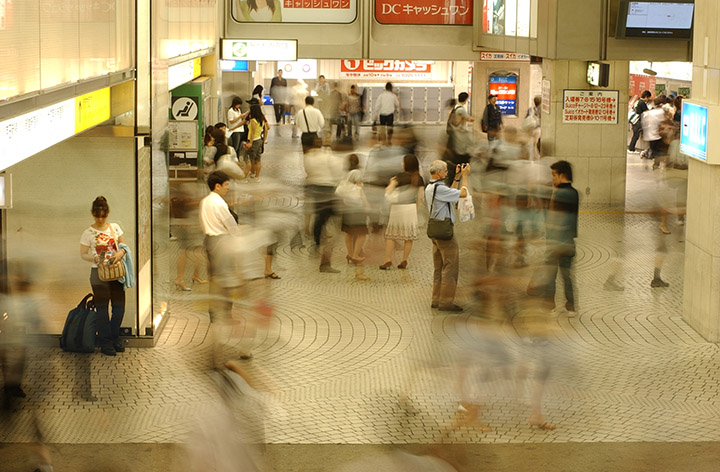

In [3]:
image01_url = "https://github.com/subwaymatch/layer-is-python/blob/master/images/image02.jpg?raw=true"
response = requests.get(image01_url)
image01 = Image.open(BytesIO(response.content))

display(image01)

## PIL to Numpy conversions

### Read an image as a Numpy ndarray

In [4]:
image01_data = np.asarray(image01)
type(image01_data)

numpy.ndarray

### Numpy array into PIL image

In [5]:
img = Image.fromarray(image01_data, 'RGB')
# display(img)

### Numpy array of unsigned int pixel values to float values (0 ~ 1)

In [6]:
image01_float_data = convert_uint_to_float(image01_data)

## Convert image to grayscale

In [7]:
image01_gray = np.dot(image01_data[...,:3], [0.2989, 0.5870, 0.1140])
image01_gray_data = np.stack((round_to_uint(image01_gray),)*3, axis=-1)

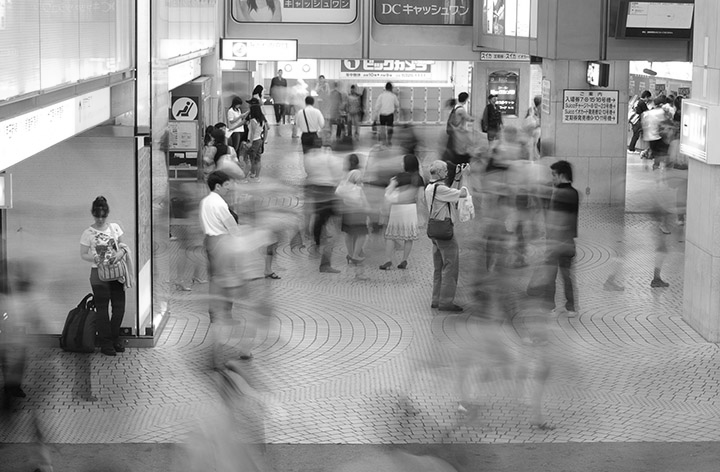

In [8]:
display_img(image01_gray_data)

## Blend Mode Operations

### Darken Operations

#### Darken

Looks at the color information in each channel and selects the base or blend color—whichever is darker—as the result color. Pixels lighter than the blend color are replaced, and pixels darker than the blend color do not change.

```
C = min(A, B)
```

In [9]:
lighten_hex = '#e6ba81'
rgb = hex_to_rgb(lighten_hex)

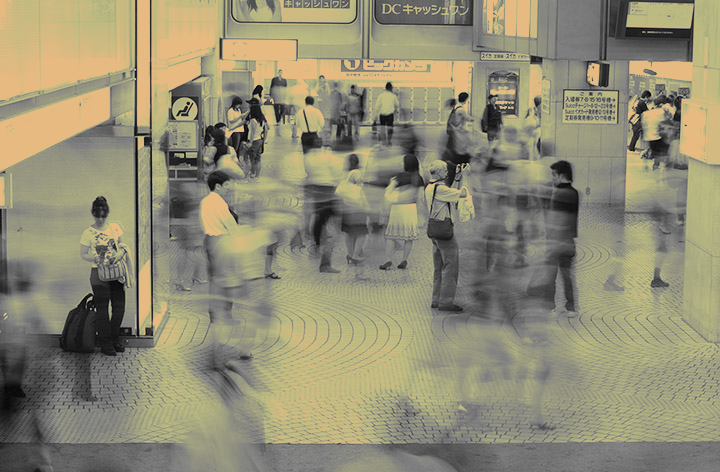

In [10]:
image01_darken = round_to_uint(np.minimum(image01_gray_data, rgb))
display_img(image01_darken)

#### Multiply

Looks at the color information in each channel and multiplies the base color by the blend color. The result color is always a darker color. Multiplying any color with black produces black. Multiplying any color with white leaves the color unchanged. When you’re painting with a color other than black or white, successive strokes with a painting tool produce progressively darker colors. The effect is similar to drawing on the image with multiple marking pens.

```
C = A * B
```

In [11]:
bright_hex = '#59ff74'
rgb_as_float = hex_to_rgb_float(bright_hex)

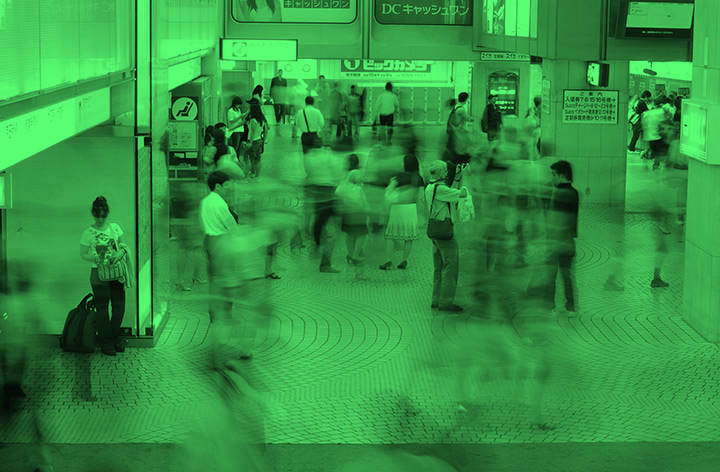

In [12]:
image01_multiply = round_to_uint(image01_gray_data * rgb_as_float)
display_img(image01_multiply)

#### Color Burn

Looks at the color information in each channel and darkens the base color to reflect the blend color by increasing the contrast between the two. Blending with white produces no change.

```
If B = 0: C = 0
Else: C = 1 - (1 - A) / B
```

In [13]:
color_burn_hex = '#b3dcff'

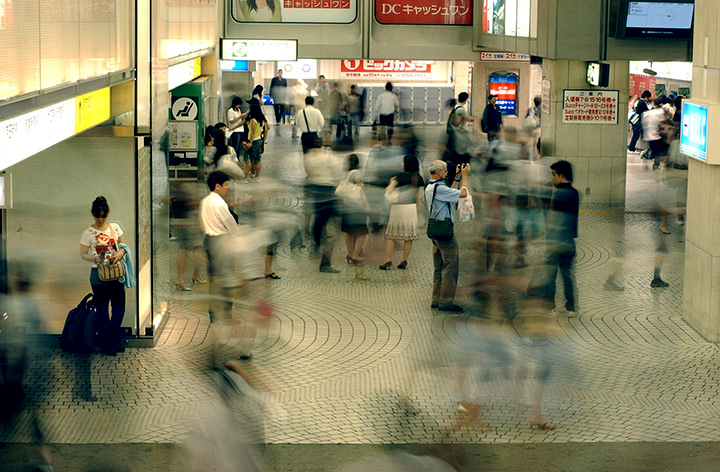

In [14]:
def color_burn(image_data, blend_data):
    if image_data.dtype == 'uint8':
        image_data = convert_uint_to_float(image_data)
        
    if isinstance(blend_data, str):
        blend_data = get_array_from_hex(blend_data, image_data.shape[0], image01_data.shape[1])
    
    A = image_data
    B = blend_data
    
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.clip(np.where(B > 0, 1 - (1 - A) / B, 0), 0, 1)

image01_color_burn = color_burn(image01_data, color_burn_hex)
display_img(convert_float_to_uint(image01_color_burn))

#### Linear Burn

Looks at the color information in each channel and darkens the base color to reflect the blend color by decreasing the brightness. Blending with white produces no change.

```
C = A + B - 1
```

In [15]:
linear_burn_hex = '#f8a5ff'
rgb = hex_to_rgb(linear_burn_hex)
rgb

array([248, 165, 255])

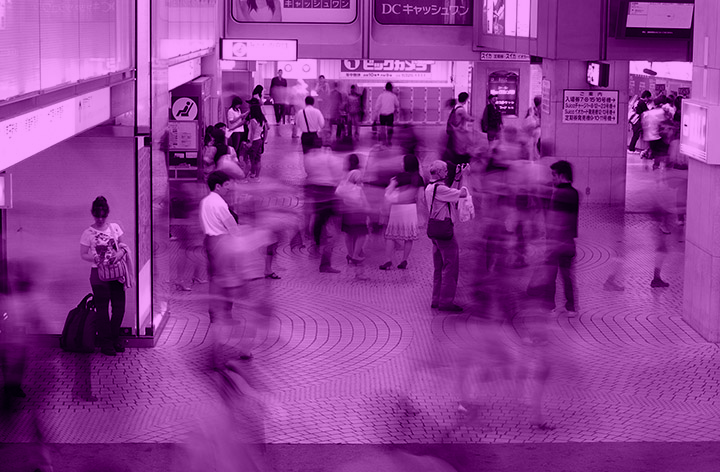

In [16]:
A = image01_gray_data
B = rgb

image01_linear_burn = np.clip(A + B - 255, 0, 255).astype('uint8')
display_img(image01_linear_burn)

### Lighten Operations

#### Lighten

Looks at the color information in each channel and selects the base or blend color—whichever is lighter—as the result color. Pixels darker than the blend color are replaced, and pixels lighter than the blend color do not change.

```
max(A, B)
```

In [17]:
lighten_hex = '#455c6f'
rgb = hex_to_rgb(lighten_hex)

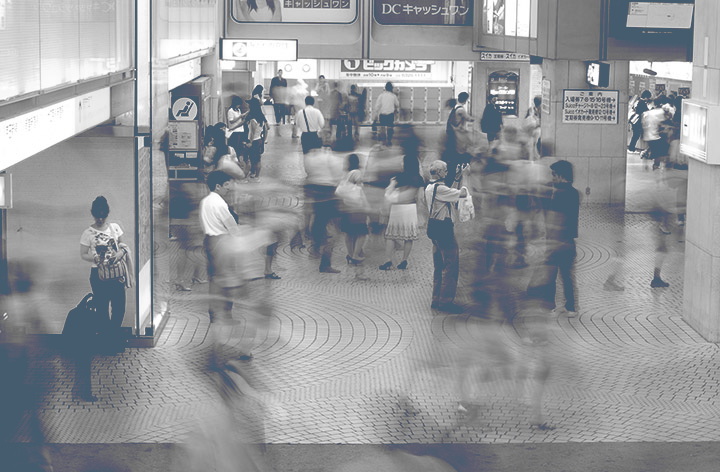

In [18]:
image01_lighten = round_to_uint(np.maximum(image01_gray_data, rgb))
display_img(image01_lighten)

#### Screen

Looks at each channel’s color information and multiplies the inverse of the blend and base colors. The result color is always a lighter color. Screening with black leaves the color unchanged. Screening with white produces white. The effect is similar to projecting multiple photographic slides on top of each other.

```
C = 1 - (1 - A) * (1 - B)
```

In [19]:
screen_hex = '#215471'
rgb_as_float = hex_to_rgb_float(screen_hex)
rgb_as_float

array([0.12941176, 0.32941176, 0.44313725])

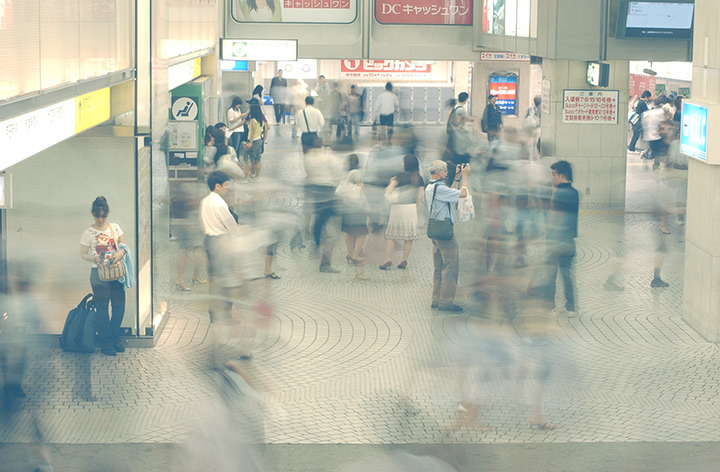

In [20]:
A = image01_float_data
B = rgb_as_float

image01_screen = 1 - (1 - A) * (1 - B)
display_img(convert_float_to_uint(image01_screen))

#### Color Dodge

Looks at the color information in each channel and brightens the base color to reflect the blend color by decreasing contrast between the two. Blending with black produces no change.

```
C = A / (1 - B)
```

In [21]:
color_dodge_rgb = '#0f3d64'
rgb_as_float = hex_to_rgb_float(color_dodge_rgb)
color_dodge_rgb

'#0f3d64'

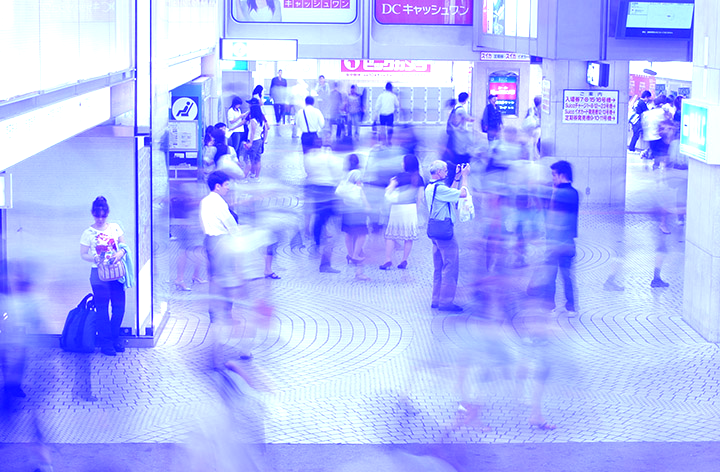

In [22]:
color_dodge_rgb = '#0f3dff'

def color_dodge(image_data, blend_data):
    if image_data.dtype == 'uint8':
        image_data = convert_uint_to_float(image_data)
        
    if isinstance(blend_data, str):
        #blend_data = hex_to_rgb_float(blend_data)
        blend_data = get_array_from_hex(blend_data, image_data.shape[0], image_data.shape[1])
    
    A = image_data
    B = blend_data
    
    with np.errstate(divide='ignore', invalid='ignore'):
        C = np.where(B == 1, B, np.clip(A / (1 - B), 0, 1))
        
    return C

image01_color_dodge = color_dodge(image01_data, color_dodge_rgb)
display_img(convert_float_to_uint(image01_color_dodge))

#### Linear Dodge

Looks at the color information in each channel and brightens the base color to reflect the blend color by increasing the brightness. Blending with black produces no change.

```
C = A + B
```

In [23]:
linear_dodge_hex = '#40421e'
rgb_as_float = hex_to_rgb_float(linear_dodge_hex)

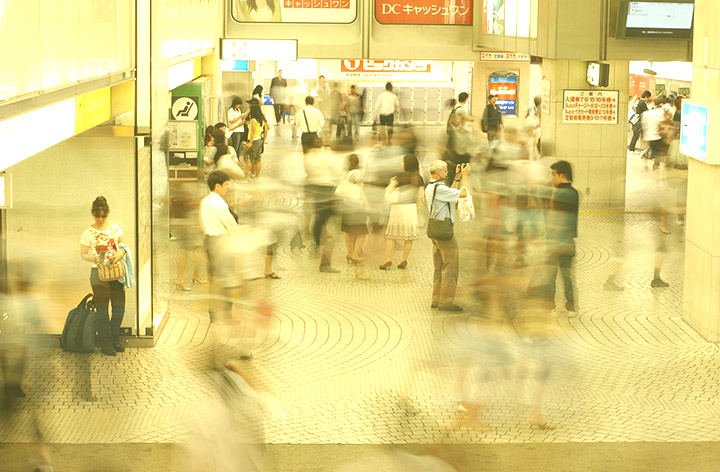

In [24]:
A = image01_float_data
B = rgb_as_float

image01_linear_dodge = np.clip(A + B, 0, 1)
display_img(convert_float_to_uint(image01_linear_dodge))

### Contrast Operations



#### Overlay

Multiplies or screens the colors, depending on the base color. Patterns or colors overlay the existing pixels while preserving the highlights and shadows of the base color. The base color is not replaced, but mixed with the blend color to reflect the lightness or darkness of the original color.

```
If A <= 0.5: (2 * A) * B
Else: 1 - 2 * (1 - A) * (1 - B)
```

In [25]:
overlay_hex = '#9facd6'
rgb_as_float = hex_to_rgb_float(overlay_hex)

In [26]:
data01 = (2 * image01_float_data) * rgb_as_float
data02 = 1 - 2 * (1 - image01_float_data) * (1 - rgb_as_float)

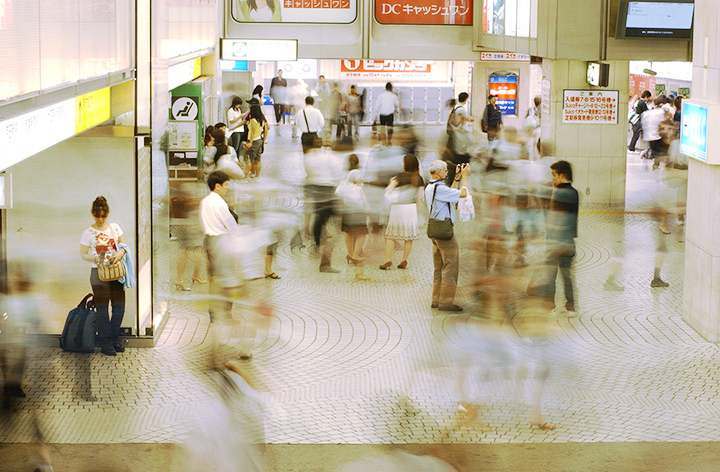

In [27]:
image01_overlay = np.where(image01_float_data <= 0.5, data01, data02)
display_img(convert_float_to_uint(image01_overlay))

#### Soft Light

Darkens or lightens the colors, depending on the blend color. The effect is similar to shining a diffused spotlight on the image. If the blend color (light source) is lighter than 50% gray, the image is lightened as if it were dodged. If the blend color is darker than 50% gray, the image is darkened as if it were burned in. Painting with pure black or white produces a distinctly darker or lighter area, but does not result in pure black or white.

```
If B <= 0.5: 2 * A * B + A^2 * (1 - 2 * B)
ELSE: sqrt(A) * (2 * B - 1) + (2 * A) * (1 - B)
```

In [28]:
soft_light_hex = '#274c7f'

In [29]:
soft_light_color_array = get_array_from_hex(soft_light_hex, image01_data.shape[0], image01_data.shape[1])

a = image01_float_data
b = rgb_as_float

data01 = 2 * a * b + np.square(a) * (1 - 2 * b)
data02 = np.sqrt(a) * (2 * b - 1) + (2 * a) * (1 - b)

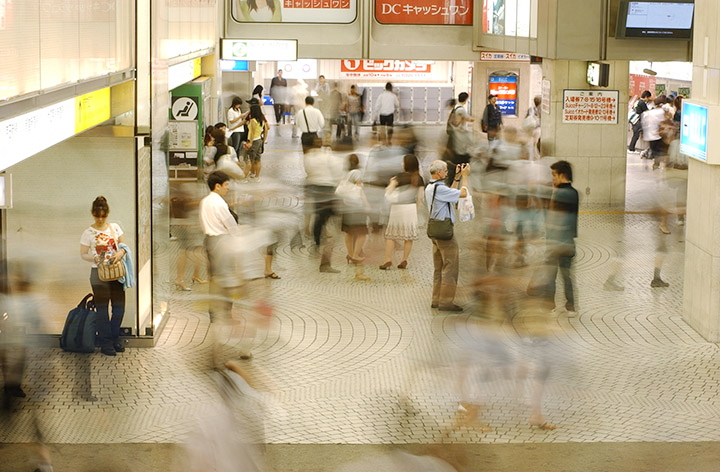

In [30]:
image01_soft_light = np.where(soft_light_color_array <= 0.5, data01, data02)
display_img(convert_float_to_uint(image01_soft_light))

#### Hard Light

Multiplies or screens the colors, depending on the blend color. The effect is similar to shining a harsh spotlight on the image. If the blend color (light source) is lighter than 50% gray, the image is lightened, as if it were screened. This is useful for adding highlights to an image. If the blend color is darker than 50% gray, the image is darkened, as if it were multiplied. This is useful for adding shadows to an image. Painting with pure black or white results in pure black or white.

```
If (B <= 0.5): (2 * A) * B
ELSE (B > 0.5): 1 - 2 * (1 - A) * (1 - B)
```

In [31]:
hard_light_hex = '#931919'
rgb_as_float = hex_to_rgb_float(hard_light_hex)

In [32]:
hard_light_color_array = get_array_from_hex(hard_light_hex, image01_data.shape[0], image01_data.shape[1])

data01 = (2 * image01_float_data) * rgb_as_float
data02 = 1 - 2 * (1 - image01_float_data) * (1 - rgb_as_float)

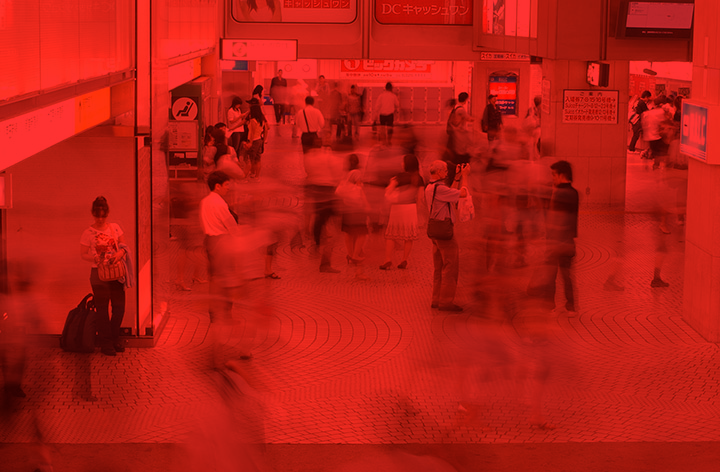

In [33]:
image01_hard_light = np.where(hard_light_color_array <= 0.5, data01, data02)
display_img(convert_float_to_uint(image01_hard_light))

#### Vivid Light

Burns or dodges the colors by increasing or decreasing the contrast, depending on the blend color. If the blend color (light source) is lighter than 50% gray, the image is lightened by decreasing the contrast. If the blend color is darker than 50% gray, the image is darkened by increasing the contrast.

```
IF B <= 0.5: (A / (1 - 2 * B))	
ELSE: (1 - (1 - A) / (2 * (B - 0.5))) +

```

In [48]:
vivid_light_hex = '#6f9886'

In [53]:
def vivid_light(image_data, blend_data):
    if image_data.dtype == 'uint8':
        image_data = convert_uint_to_float(image_data)
        
    if isinstance(blend_data, str):
        blend_data = hex_to_rgb_float(blend_data)
    
    A = image_data
    B = blend_data
    
    with np.errstate(divide='ignore', invalid='ignore'):
        image_color_burn = np.where(B > 0, 1 - (1 - A) / (2 * B), 0)
        image_color_dodge = np.where(B < 1, A / (2 * (1 - B)), 1)
    
    return np.clip(np.where(B <= 0.5, image_color_burn, image_color_dodge), 0, 1)

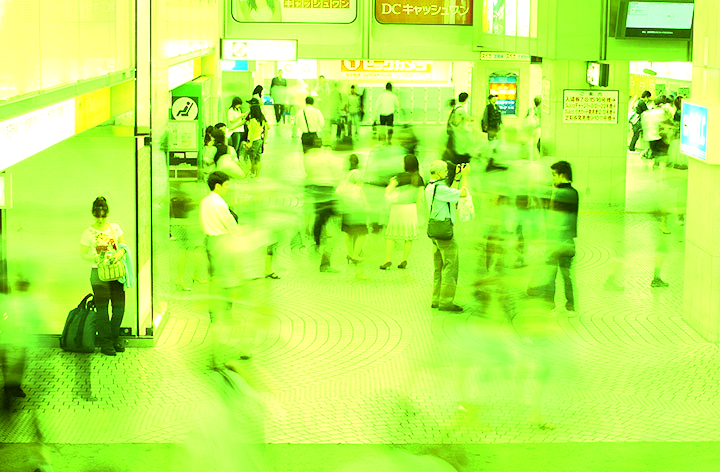

In [52]:
image01_vivid_light = vivid_light(image01_data, vivid_light_hex)
display_img(convert_float_to_uint(image01_vivid_light))

#### Linear Light

Burns or dodges the colors by decreasing or increasing the brightness, depending on the blend color. If the blend color (light source) is lighter than 50% gray, the image is lightened by increasing the brightness. If the blend color is darker than 50% gray, the image is darkened by decreasing the brightness.

```
C = A + (2 * B) - 1
```

In [37]:
linear_light_hex = '#23941d'

In [38]:
A = image01_float_data
B = rgb_as_float

def linear_light(image_data, blend_data):
    if image_data.dtype == 'uint8':
        image_data = convert_uint_to_float(image_data)
        
    if isinstance(blend_data, str):
        blend_data = hex_to_rgb_float(blend_data)
    
    A = image_data
    B = blend_data
    
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.clip(A + 2 * B - 1, 0, 1)

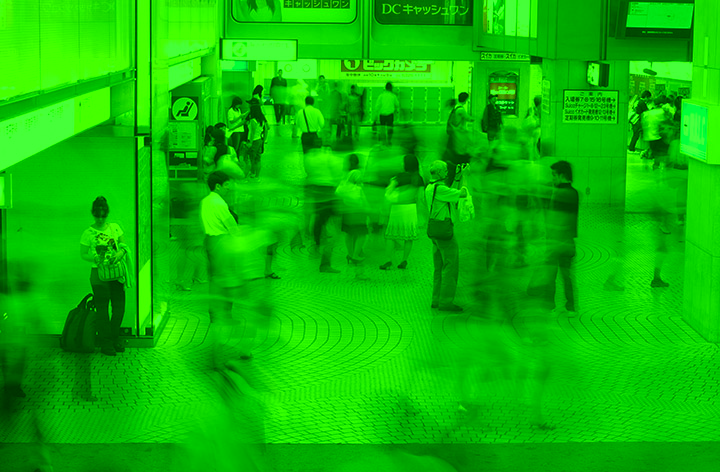

In [39]:
image01_linear_light = linear_light(image01_data, linear_light_hex)
display_img(convert_float_to_uint(image01_linear_light))

#### Pin Light


Replaces the colors, depending on the blend color. If the blend color (light source) is lighter than 50% gray, pixels darker than the blend color are replaced, and pixels lighter than the blend color do not change. If the blend color is darker than 50% gray, pixels lighter than the blend color are replaced, and pixels darker than the blend color do not change. This is useful for adding special effects to an image.

```
If A < 2 * B - 1: C = 2 * B - 1
ELSE IF 

```

In [40]:
pin_light_hex = '#f467de'

In [41]:
A = image01_float_data
B = rgb_as_float

def linear_light(image_data, blend_data):
    if image_data.dtype == 'uint8':
        image_data = convert_uint_to_float(image_data)
        
    if isinstance(blend_data, str):
        blend_data = hex_to_rgb_float(blend_data)
    
    A = image_data
    B = blend_data
    
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.clip(A + 2 * B - 1, 0, 1)

#### Hard Mix


Adds the red, green and blue channel values of the blend color to the RGB values of the base color. If the resulting sum for a channel is 255 or greater, it receives a value of 255; if less than 255, a value of 0. Therefore, all blended pixels have red, green, and blue channel values of either 0 or 255. This changes all pixels to primary additive colors (red, green, or blue), white, or black.

### Component Operations

#### Hue

Creates a result color with the luminance and saturation of the base color and the hue of the blend color.

#### Saturation

Creates a result color with the luminance and hue of the base color and the saturation of the blend color. Painting with this mode in an area with no (0) saturation (gray) causes no change.

#### Color

Creates a result color with the luminance of the base color and the hue and saturation of the blend color. This preserves the gray levels in the image and is useful for coloring monochrome images and for tinting color images.

#### Luminosity

Creates a result color with the hue and saturation of the base color and the luminance of the blend color. This mode creates the inverse effect of Color mode.